In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.patches as patches
import os
import cv2
import pickle
#import cvlib as cv
#from cvlib.object_detection import draw_bbox
import random
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import plot_model
from keras import Input

In [48]:
import sys
np.set_printoptions(threshold=1000)


In [2]:
train = pd.read_csv("Train.csv")
train = train.sort_values("ClassId").reset_index().drop(["index"], axis = 1)
test = pd.read_csv("Test.csv")

In [3]:
train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,30,30,5,5,25,25,0,Train/0/00000_00002_00006.png
1,70,74,7,7,64,68,0,Train/0/00000_00004_00014.png
2,72,75,7,6,65,68,0,Train/0/00000_00004_00015.png
3,74,79,7,7,68,72,0,Train/0/00000_00004_00016.png
4,74,80,6,8,67,73,0,Train/0/00000_00004_00017.png
...,...,...,...,...,...,...,...,...
39204,40,43,5,6,35,38,42,Train/42/00042_00002_00024.png
39205,42,44,5,5,37,39,42,Train/42/00042_00002_00025.png
39206,45,47,6,6,40,42,42,Train/42/00042_00002_00026.png
39207,68,71,6,6,62,65,42,Train/42/00042_00003_00028.png


#### Define classes names.

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }
num_classes = len(classes)

#### Check the amount of images of each class in the train set to identify possible dataset unbalance. 

Text(40, 1050, 'Pretended Images: 1000.00')

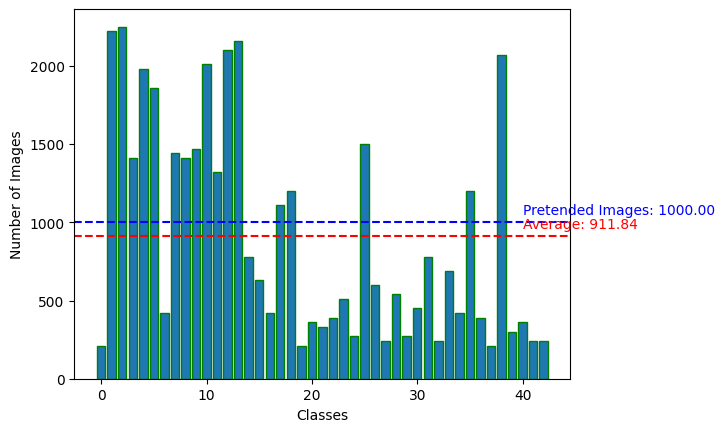

In [5]:
numImages = {}
for i in range(0, num_classes):
    numImages[i] = len(train[train['ClassId'] == i])

plt.bar(numImages.keys(), numImages.values(), edgecolor="green")
plt.xlabel('Classes')
plt.ylabel('Number of Images')
average = np.mean(list(numImages.values()))
plt.axhline(average, color='r', linestyle='--', label='Average')
plt.text(40, average + 50, f"Average: {average:.2f}", color='red')
plt.axhline(1000, color='b', linestyle='--', label='Pretended Images')
plt.text(40, 1000 + 50, f"Pretended Images: {1000:.2f}", color='blue')

#### Check images's resolution by plotting Width and Height. The size of the dots represent the aspect ratio of the image.

Text(0, 0.5, 'Height')

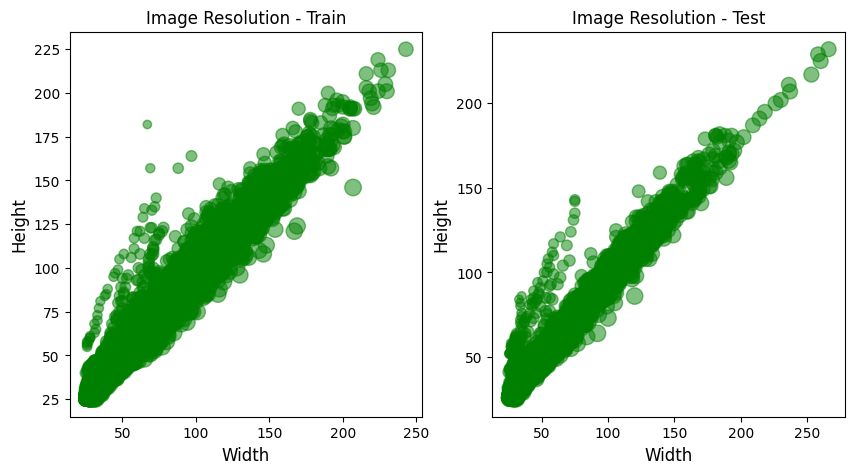

In [6]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
points = ax.scatter(train.Width, train.Height, color='green', alpha=0.5, s=(train.Width/train.Height)*100,  picker=True)
ax.set_title("Image Resolution - Train")
ax.set_xlabel("Width", size=12)
ax.set_ylabel("Height", size=12)
ax2 = fig.add_subplot(122)
points = ax2.scatter(test.Width, test.Height, color='green', alpha=0.5, s=(test.Width/test.Height)*100,  picker=True)
ax2.set_title("Image Resolution - Test")
ax2.set_xlabel("Width", size=12)
ax2.set_ylabel("Height", size=12)

#### Create a function to preprocess the images into a numpy array which is required for the model input.

In [7]:
def image_preprocessing(image):
    image = image.resize((32,32))
    image_array = np.array(image)
    return image_array

#### Define X_train, y_train and roi_train.

In [8]:
X_train = []
y_train = []
for index, path in enumerate(train.Path):
    try:
        image = Image.open(path)
        image_array = image_preprocessing(image)
        X_train.append(image_array)
        y_train.append(train['ClassId'].iloc[index])
    except:
        print("Error in " + path)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [9]:
roi_train = []
for i in range(0, len(train)):
    roi_x1, roi_y1, roi_x2, roi_y2 = train['Roi.X1'].iloc[i], train['Roi.Y1'].iloc[i], train['Roi.X2'].iloc[i], train['Roi.Y2'].iloc[i]
    # Adjust bounding box coordinates for resizing
    resized_roi_x1 = round(roi_x1 * 32 / train['Width'].iloc[i])
    resized_roi_y1 = round(roi_y1 * 32 / train['Height'].iloc[i])
    resized_roi_x2 = round(roi_x2 * 32 / train['Width'].iloc[i])
    resized_roi_y2 = round(roi_y2 * 32 / train['Height'].iloc[i])
    roi_train.append([resized_roi_x1, resized_roi_y1, resized_roi_x2, resized_roi_y2])
    if i in [1000, 5000, 10000, 20000, 30000, 35000]:
        print(i)
roi_train = np.array(roi_train)

1000
5000
10000
20000
30000
35000


#### One hot encode the classes in y_train.

In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
print(X_train.shape)
print(y_train.shape)
print(roi_train.shape)

(39209, 32, 32, 3)
(39209, 43)
(39209, 4)


In [49]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

#### Define X_test, y_test and roi_test.

In [11]:
X_test = []
y_test = []
for index, path in enumerate(test.Path):
    try:
        image = Image.open(path)
        image_array = image_preprocessing(image)
        X_test.append(image_array)
        y_test.append(test['ClassId'].iloc[index])
    except:
        print("Error in " + path)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [12]:
roi_test = []
for i in range(0, len(test)):
    roi_x1, roi_y1, roi_x2, roi_y2 = test['Roi.X1'].iloc[i], test['Roi.Y1'].iloc[i], test['Roi.X2'].iloc[i], test['Roi.Y2'].iloc[i]
    # Adjust bounding box coordinates for resizing
    resized_roi_x1 = round(roi_x1 * 32 / test['Width'].iloc[i])
    resized_roi_y1 = round(roi_y1 * 32 / test['Height'].iloc[i])
    resized_roi_x2 = round(roi_x2 * 32 / test['Width'].iloc[i])
    resized_roi_y2 = round(roi_y2 * 32 / test['Height'].iloc[i])
    roi_test.append([resized_roi_x1, resized_roi_y1, resized_roi_x2, resized_roi_y2])
    if i in [1000, 5000, 10000, 20000, 30000, 35000]:
        print(i)
roi_test = np.array(roi_test)

1000
5000
10000


In [13]:
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_test.shape)
print(y_test.shape)
print(roi_test.shape)

(12630, 32, 32, 3)
(12630, 43)
(12630, 4)


#### Image augmentation and reduction of each class to a 1000.

In [14]:
indexes_to_delete = []
count = 0
for label, images_num in enumerate(numImages.values()):
    if images_num > 1000:
        np.random.shuffle(X_train[count:count+images_num])
        downsize = images_num - 1000
        indexes = [x for x in range(count, count+downsize)]
        indexes_to_delete.append(indexes)
        count = count + images_num
    else:
        count = count + images_num
indexes_to_delete = sum(indexes_to_delete, [])
X_train = np.delete(X_train, indexes_to_delete, axis = 0)
y_train = np.delete(y_train, indexes_to_delete, axis = 0)
roi_train = np.delete(roi_train, indexes_to_delete, axis = 0)
print(X_train.shape)
print(y_train.shape)
print(roi_train.shape)

(27499, 32, 32, 3)
(27499, 43)
(27499, 4)


In [15]:
image_generator = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.2,
    fill_mode="nearest")

In [16]:
X_train2 = X_train.copy()
y_train2 = list(y_train.copy())
roi_train2 = list(roi_train.copy())
count = 0
for label, images_num in enumerate(np.sum(y_train, axis=0)):
    if int(images_num) < 1000:
        augmentation = 1000 - int(images_num)
        while augmentation != 0:
            index = random.randint(count, count+int(images_num)-1)
    
            image = X_train[index]
            params = image_generator.get_random_transform((1,32,32,3))
            width_shift = params['tx']
            height_shift = params['ty']
            zoom_x = params['zx']
            zoom_y = params['zy']
            image = image_generator.apply_transform(image, params)
            image = np.expand_dims(image, axis=0)
            
            X_train2 = np.concatenate((X_train2, image), axis=0)
            y_train2.append(keras.utils.to_categorical(label, num_classes=num_classes))
            
            rx1, ry1, rx2, ry2 = roi_train[index]
            roi_x1 = round((rx1 + width_shift) * zoom_x)
            roi_x2 = round((rx2 + width_shift) * zoom_x)
            roi_y1 = round((ry1 - height_shift ) * zoom_y)
            roi_y2 = round((ry2 - height_shift ) * zoom_y)
            
            roi_train2.append([roi_x1, roi_y1, roi_x2, roi_y2])
            augmentation = augmentation - 1
        count = count + int(images_num)
    else:
        count = count + int(images_num)



In [17]:
X_train2 = np.array(X_train2)
y_train2 = np.array(y_train2)
roi_train2 = np.array(roi_train2)

In [18]:
X_train = X_train2.copy()
y_train = y_train2.copy()
roi_train = roi_train2.copy()

In [19]:
print(X_train.shape)
print(y_train.shape)
print(roi_train.shape)

(43000, 32, 32, 3)
(43000, 43)
(43000, 4)


#### Verify image example from train set.

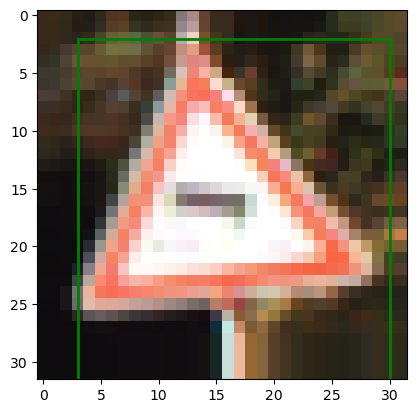

In [20]:
index = 33212
r1x, r1y, r2x, r2y = roi_train[index]
#print(y_train2[index])
image_test = X_train2[index]
fig, ax = plt.subplots()
ax.imshow(image_test)
roi_width = (r2x - r1x)
roi_height = (r2y - r1y)
rect = patches.Rectangle((r1x, r1y), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.show()

#### Check the new train set balance

Text(40, 1055, 'threshold: 1000')

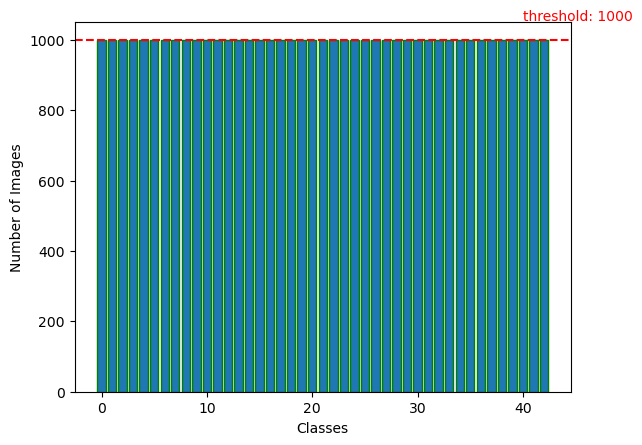

In [21]:
x = np.sum(y_train, axis = 0)
plt.bar(range(0,43), np.sum(y_train, axis=0), edgecolor="green")
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.axhline(1000, color='r', linestyle='--', label='1000 threshold')
plt.text(40, 1000 + 55, f"threshold: {1000}", color='red')

#### Normalize input images

In [22]:
X_train = X_train/255
X_test = X_test/255

#### Create model that classifies the images and predicts ROI position in the image.

In [23]:
#Shuffle the data the samee way in each variabe
indices = np.random.permutation(len(X_train))

X_train = X_train[indices]
y_train = y_train[indices]
roi_train = roi_train[indices]

#### Save and load pickle of variables (faster than running the script above each time)

In [24]:
with open('X_train.pickle', 'wb') as f:
    pickle.dump(X_train, f)
with open('y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)
with open('roi_train.pickle', 'wb') as f:
    pickle.dump(roi_train, f)

with open('X_test.pickle', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)
with open('roi_test.pickle', 'wb') as f:
    pickle.dump(roi_test, f)

In [4]:
with open('X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)
with open('y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)
with open('roi_train.pickle', 'rb') as f:
    roi_train = pickle.load(f)

with open('X_test.pickle', 'rb') as f:
    X_test = pickle.load(f)
with open('y_test.pickle', 'rb') as f:
    y_test = pickle.load(f)
with open('roi_test.pickle', 'rb') as f:
    roi_test = pickle.load(f)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


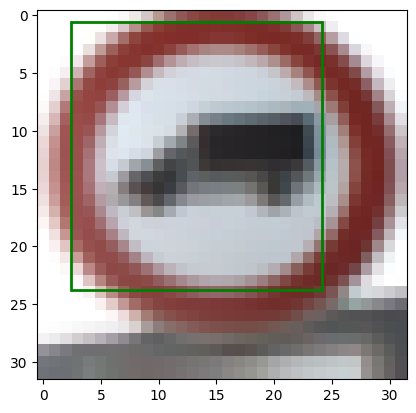

In [42]:
index = 23976
image = X_train[index]
params = image_generator.get_random_transform((1,32,32,3))
width_shift = params['tx']
height_shift = params['ty']
zoom_x = params['zx']
zoom_y = params['zy']
image = image_generator.apply_transform(image, params)
image = np.expand_dims(image, axis = 0)
rx1, ry1, rx2, ry2 = roi_train[index]
print(y_train[index])
fig, ax = plt.subplots()
ax.imshow(image[0])
roi_x1 = (rx1 + width_shift) * zoom_x 
roi_x2 = (rx2 + width_shift) * zoom_x
roi_y1 = (ry1 - height_shift ) * zoom_y
roi_y2 = (ry2 - height_shift ) * zoom_y
roi_width = (roi_x2 - roi_x1)
roi_height = (roi_y2 - roi_y1)
rect = patches.Rectangle((roi_x1, roi_y1), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.show()

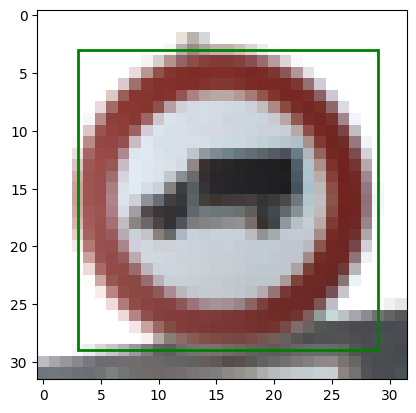

In [43]:
fig, ax = plt.subplots()
ax.imshow(X_train[index])
roi_width = (rx2 - rx1)
roi_height = (ry2 - ry1)
rect = patches.Rectangle((rx1, ry1), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.show()

#### CNN1

In [ ]:
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(input_layer)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)

label_output = Dense(43, activation='softmax', name='label_output')(x)
roi_output = Dense(4, activation='linear', name='roi_output')(x)

model = Model(inputs=input_layer, outputs=[label_output, roi_output])


In [ ]:
model.compile(optimizer='adam',
              loss={'label_output': 'categorical_crossentropy', 'roi_output': 'mean_squared_error'},
              metrics={'label_output': 'accuracy', 'roi_output': 'mean_squared_error'})

In [ ]:
history = model.fit(X_train, {'label_output': y_train, 'roi_output': roi_train}, epochs=30, batch_size=32, validation_data=(X_test, [y_test, roi_test]))
with open('CNNHistory1.pickle', 'wb') as f:
    pickle.dump(history.history, f)
model.save('CNN1.h5')

In [5]:
# Load model
with open('CNNHistory1.pickle', 'rb') as f:
    historyCNN1 = pickle.load(f)
    
CNN1 = load_model("CNN1.h5") 

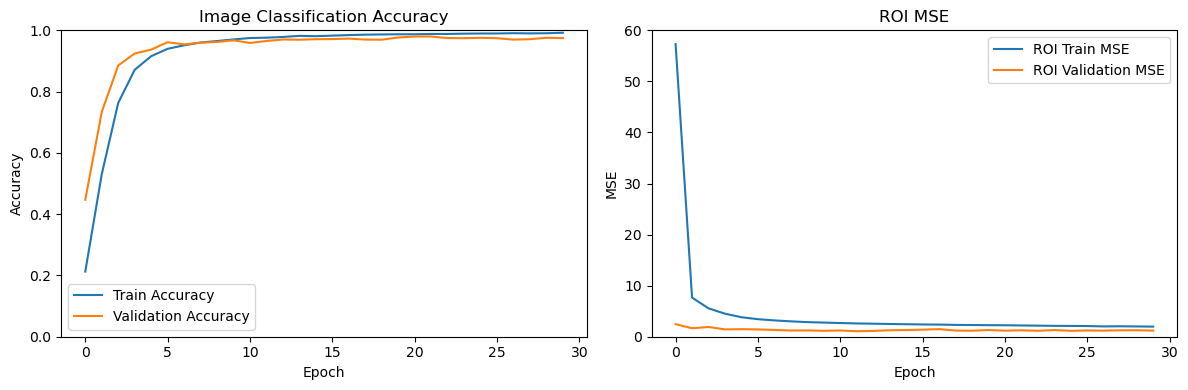

In [6]:
# Get the accuracy and mse values from the history object
label_loss = historyCNN1['label_output_loss']
roi_loss = historyCNN1['roi_output_loss']
label_acc = historyCNN1['label_output_accuracy']
roi_mse = historyCNN1['roi_output_mean_squared_error']
val_label_loss = historyCNN1['val_label_output_loss']
val_roi_loss = historyCNN1['val_roi_output_loss']
val_label_acc = historyCNN1['val_label_output_accuracy']
val_roi_mse = historyCNN1['val_roi_output_mean_squared_error']

# Plot the Label Graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Image Classification Accuracy")
plt.plot(label_acc, label='Train Accuracy')
plt.plot(val_label_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Set the y-axis limits
plt.legend()

# Plot the ROI Graph
plt.subplot(1, 2, 2)
plt.title("ROI MSE")
plt.plot(roi_mse, label='ROI Train MSE')
plt.plot(val_roi_mse, label='ROI Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([0, 60])  # Set the y-axis limits
plt.legend()

plt.tight_layout()
plt.show()

#### CNN2

In [33]:
input_layer = Input(shape=(32, 32, 3))
x = Conv2D(8, (5, 5), activation='relu')(input_layer)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)

label_output = Dense(43, activation='softmax', name='label_output')(x)
roi_output = Dense(4, activation='linear', name='roi_output')(x)

CNN2 = Model(inputs=input_layer, outputs=[label_output, roi_output])


In [34]:
CNN2.compile(optimizer='adam',
              loss={'label_output': 'categorical_crossentropy', 'roi_output': 'mean_squared_error'},
              metrics={'label_output': 'accuracy', 'roi_output': 'mean_squared_error'})

In [35]:
history = CNN2.fit(X_train, {'label_output': y_train, 'roi_output': roi_train}, epochs=30, batch_size=32, validation_data=(X_test, [y_test, roi_test]))
with open('CNNHistory2.pickle', 'wb') as f:
    pickle.dump(history.history, f)
CNN2.save('CNN2.h5')

Epoch 1/30
1344/1344 [==============================] - 21s 15ms/step - loss: 91.9056 - label_output_loss: 3.9259 - roi_output_loss: 87.9799 - label_output_accuracy: 0.0553 - roi_output_mean_squared_error: 87.9799 - val_loss: 5.6544 - val_label_output_loss: 3.6747 - val_roi_output_loss: 1.9797 - val_label_output_accuracy: 0.0614 - val_roi_output_mean_squared_error: 1.9797
Epoch 2/30
1344/1344 [==============================] - 21s 16ms/step - loss: 15.2260 - label_output_loss: 3.4970 - roi_output_loss: 11.7290 - label_output_accuracy: 0.0876 - roi_output_mean_squared_error: 11.7290 - val_loss: 5.1594 - val_label_output_loss: 3.4609 - val_roi_output_loss: 1.6986 - val_label_output_accuracy: 0.0683 - val_roi_output_mean_squared_error: 1.6986
Epoch 3/30
1344/1344 [==============================] - 21s 16ms/step - loss: 12.1859 - label_output_loss: 3.0689 - roi_output_loss: 9.1170 - label_output_accuracy: 0.1685 - roi_output_mean_squared_error: 9.1170 - val_loss: 4.0072 - val_label_output_

In [7]:
# Load model
with open('CNNHistory2.pickle', 'rb') as f:
    historyCNN2 = pickle.load(f)
    
CNN2 = load_model("CNN2.h5") 

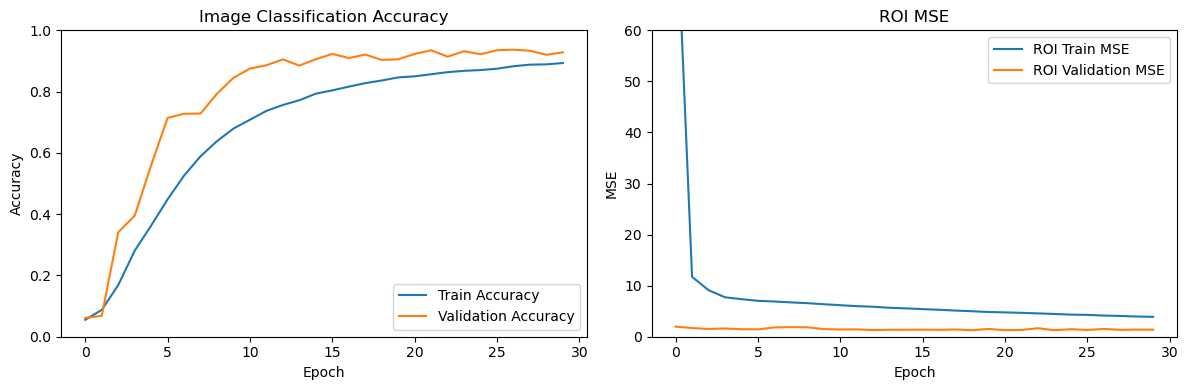

In [8]:
# Get the accuracy and mse values from the history object
label_loss2 = historyCNN2['label_output_loss']
roi_loss2 = historyCNN2['roi_output_loss']
label_acc2 = historyCNN2['label_output_accuracy']
roi_mse2 = historyCNN2['roi_output_mean_squared_error']
val_label_loss2 = historyCNN2['val_label_output_loss']
val_roi_loss2 = historyCNN2['val_roi_output_loss']
val_label_acc2 = historyCNN2['val_label_output_accuracy']
val_roi_mse2 = historyCNN2['val_roi_output_mean_squared_error']

# Plot the Label Graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Image Classification Accuracy")
plt.plot(label_acc2, label='Train Accuracy')
plt.plot(val_label_acc2, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Set the y-axis limits
plt.legend()

# Plot the ROI Graph
plt.subplot(1, 2, 2)
plt.title("ROI MSE")
plt.plot(roi_mse2, label='ROI Train MSE')
plt.plot(val_roi_mse2, label='ROI Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([0, 60])  # Set the y-axis limits
plt.legend()

plt.tight_layout()
plt.show()

#### Transfer Learning 1

In [53]:
input_layer = Input(shape=(32, 32, 3))

resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=input_layer,
    pooling='avg'
)

for layer in resnet_model.layers:
    layer.trainable = False

x = resnet_model.output

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)

label_output = Dense(43, activation='softmax', name='label_output')(x)
roi_output = Dense(4, activation='linear', name='roi_output')(x)

pre_trained_model1 = Model(inputs=input_layer, outputs=[label_output, roi_output])


In [54]:
pre_trained_model1.compile(optimizer='adam',
                           loss={'label_output': 'categorical_crossentropy', 'roi_output': 'mean_squared_error'},
                           metrics={'label_output': 'accuracy', 'roi_output': 'mean_squared_error'})


In [55]:
pre_history1 = pre_trained_model1.fit(X_train, {'label_output': y_train, 'roi_output': roi_train},
                                      epochs=30, batch_size=32,
                                      validation_data=(X_test, {'label_output': y_test, 'roi_output': roi_test}))
with open('preHistory1.pickle', 'wb') as f:
    pickle.dump(pre_history1.history, f)
pre_trained_model1.save('pre1.h5')

Epoch 1/30
1344/1344 [==============================] - 116s 85ms/step - loss: 44.1279 - label_output_loss: 3.4599 - roi_output_loss: 40.6681 - label_output_accuracy: 0.1156 - roi_output_mean_squared_error: 40.6681 - val_loss: 6.4182 - val_label_output_loss: 4.4679 - val_roi_output_loss: 1.9503 - val_label_output_accuracy: 0.0762 - val_roi_output_mean_squared_error: 1.9503
Epoch 2/30
1344/1344 [==============================] - 117s 87ms/step - loss: 9.1847 - label_output_loss: 2.8552 - roi_output_loss: 6.3295 - label_output_accuracy: 0.2218 - roi_output_mean_squared_error: 6.3295 - val_loss: 9.7015 - val_label_output_loss: 4.9073 - val_roi_output_loss: 4.7942 - val_label_output_accuracy: 0.0931 - val_roi_output_mean_squared_error: 4.7942
Epoch 3/30
1344/1344 [==============================] - 120s 89ms/step - loss: 8.6061 - label_output_loss: 2.5475 - roi_output_loss: 6.0586 - label_output_accuracy: 0.2912 - roi_output_mean_squared_error: 6.0586 - val_loss: 9.2868 - val_label_output_l

In [9]:
# Load model
with open('preHistory1.pickle', 'rb') as f:
    history_tf1 = pickle.load(f)
    
pre1 = load_model("pre1.h5") 

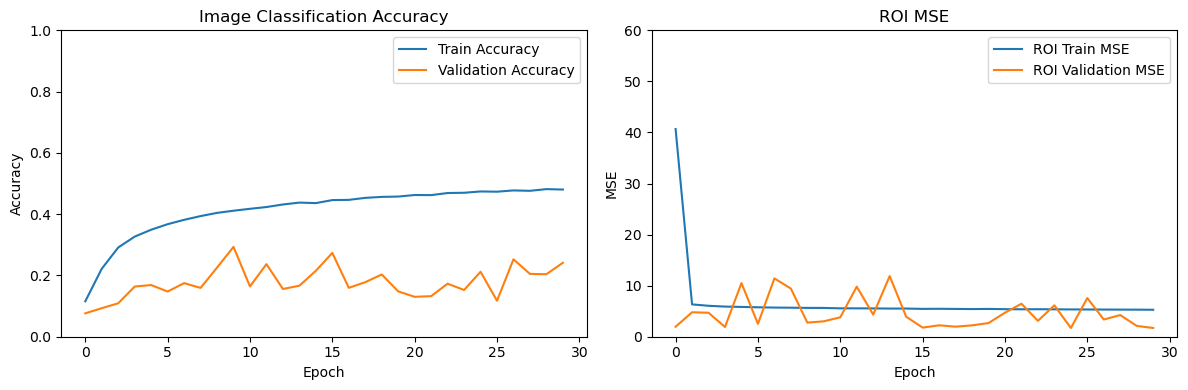

In [10]:
# Get the accuracy and mse values from the history object
label_loss_tf1 = history_tf1['label_output_loss']
roi_loss_tf1 = history_tf1['roi_output_loss']
label_acc_tf1 = history_tf1['label_output_accuracy']
roi_mse_tf1 = history_tf1['roi_output_mean_squared_error']
val_label_loss_tf1 = history_tf1['val_label_output_loss']
val_roi_loss_tf1 = history_tf1['val_roi_output_loss']
val_label_acc_tf1 = history_tf1['val_label_output_accuracy']
val_roi_mse_tf1 = history_tf1['val_roi_output_mean_squared_error']

# Plot the Label Graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Image Classification Accuracy")
plt.plot(label_acc_tf1, label='Train Accuracy')
plt.plot(val_label_acc_tf1, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Set the y-axis limits
plt.legend()

# Plot the ROI Graph
plt.subplot(1, 2, 2)
plt.title("ROI MSE")
plt.plot(roi_mse_tf1, label='ROI Train MSE')
plt.plot(val_roi_mse_tf1, label='ROI Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([0, 60])  # Set the y-axis limits
plt.legend()

plt.tight_layout()
plt.show()

#### Transfer Learning 2

In [3]:
input_layer = Input(shape=(32, 32, 3))

denseNet_model = keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=input_layer,
    pooling='avg'
)

for layer in denseNet_model.layers:
    layer.trainable = False

x = denseNet_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)


label_output = Dense(43, activation='softmax', name='label_output')(x)
roi_output = Dense(4, activation='linear', name='roi_output')(x)

pre_trained_model2 = Model(inputs=input_layer, outputs=[label_output, roi_output])


In [4]:
pre_trained_model2.compile(optimizer='adam',
                           loss={'label_output': 'categorical_crossentropy', 'roi_output': 'mean_squared_error'},
                           metrics={'label_output': 'accuracy', 'roi_output': 'mean_squared_error'})


In [5]:
pre_history2 = pre_trained_model2.fit(X_train, {'label_output': y_train, 'roi_output': roi_train},
                                      epochs=30, batch_size=32,
                                      validation_data=(X_test, {'label_output': y_test, 'roi_output': roi_test}))
with open('preHistory2.pickle', 'wb') as f:
    pickle.dump(pre_history2.history, f)
pre_trained_model2.save('pre2.h5')

Epoch 1/30
1344/1344 [==============================] - 127s 92ms/step - loss: 56.1437 - label_output_loss: 2.4876 - roi_output_loss: 53.6561 - label_output_accuracy: 0.2899 - roi_output_mean_squared_error: 53.6561 - val_loss: 3.6438 - val_label_output_loss: 1.9430 - val_roi_output_loss: 1.7008 - val_label_output_accuracy: 0.3967 - val_roi_output_mean_squared_error: 1.7008
Epoch 2/30
1344/1344 [==============================] - 124s 92ms/step - loss: 9.0381 - label_output_loss: 1.8677 - roi_output_loss: 7.1704 - label_output_accuracy: 0.4206 - roi_output_mean_squared_error: 7.1704 - val_loss: 3.4701 - val_label_output_loss: 1.7514 - val_roi_output_loss: 1.7187 - val_label_output_accuracy: 0.4496 - val_roi_output_mean_squared_error: 1.7187
Epoch 3/30
1344/1344 [==============================] - 123s 91ms/step - loss: 7.7793 - label_output_loss: 1.6234 - roi_output_loss: 6.1559 - label_output_accuracy: 0.4865 - roi_output_mean_squared_error: 6.1559 - val_loss: 3.4643 - val_label_output_l

NameError: name 'pre_trained_model1' is not defined

In [11]:
# Load model
with open('preHistory2.pickle', 'rb') as f:
    history_tf2 = pickle.load(f)
    
pre2 = load_model("pre2.h5") 

None


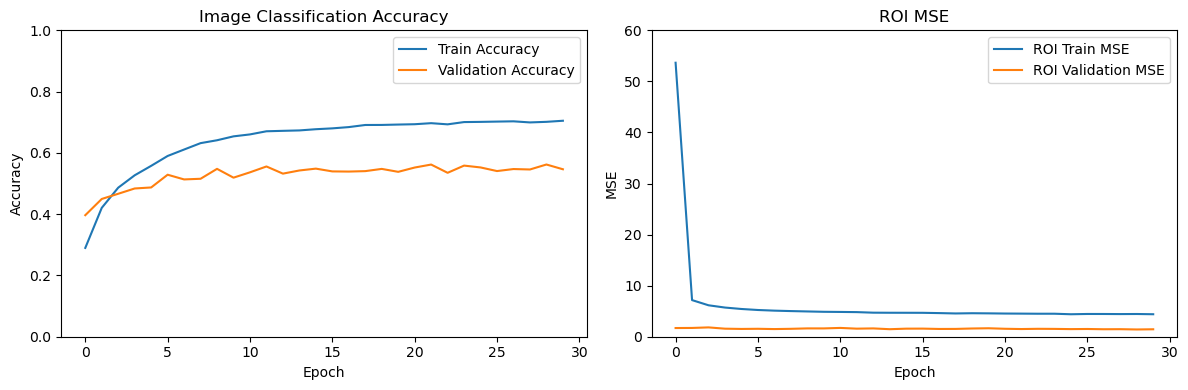

In [23]:
# Get the accuracy and mse values from the history object
label_loss_tf2 = history_tf2['label_output_loss']
roi_loss_tf2 = history_tf2['roi_output_loss']
label_acc_tf2 = history_tf2['label_output_accuracy']
roi_mse_tf2 = history_tf2['roi_output_mean_squared_error']
val_label_loss_tf2 = history_tf2['val_label_output_loss']
val_roi_loss_tf2 = history_tf2['val_roi_output_loss']
val_label_acc_tf2 = history_tf2['val_label_output_accuracy']
val_roi_mse_tf2 = history_tf2['val_roi_output_mean_squared_error']


print(pre2.history)

# Plot the Label Graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Image Classification Accuracy")
plt.plot(label_acc_tf2, label='Train Accuracy')
plt.plot(val_label_acc_tf2, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Set the y-axis limits
plt.legend()

# Plot the ROI Graph
plt.subplot(1, 2, 2)
plt.title("ROI MSE")
plt.plot(roi_mse_tf2, label='ROI Train MSE')
plt.plot(val_roi_mse_tf2, label='ROI Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([0, 60])  # Set the y-axis limits
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
pd.DataFrame({
    "Model": ['CNN1', 'CNN2', 'ResNet50', 'DenseNet121'],
    "train_accuracy": [label_acc[30-1], label_acc2[30-1], label_acc_tf1[30-1], label_acc_tf2[30-1]],
    "val_accuracy": [val_label_acc[30-1], val_label_acc2[30-1], val_label_acc_tf1[30-1], val_label_acc_tf2[30-1]],
    "train_mse": [roi_mse[30-1], roi_mse2[30-1], roi_mse_tf1[30-1], roi_mse_tf2[30-1]],
    "val_mse": [val_roi_mse[30-1], val_roi_mse2[30-1], val_roi_mse_tf1[30-1], val_roi_mse_tf2[30-1]]
})

,Model,train_accuracy,val_accuracy,train_mse,val_mse
0,CNN1,0.992116,0.974584,1.979864,1.191323
1,CNN2,0.893279,0.928345,3.893484,1.383312
2,ResNet50,0.480372,0.241409,5.278212,1.710061
3,DenseNet121,0.704884,0.546556,4.403074,1.457823


#### Extra: Attempt of video classification as final test  (initial idea as mentioned in project proposal, but not successful)

In [17]:
video_path = 'optut7.mp4'

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")
    exit()

frame_index = 1500

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
ret, frame = cap.read()

if not ret:
    print(f"Error reading frame at index {frame_index}")
    exit()

resized_frame_size = (400, 400)

resized_frame = cv2.resize(frame, resized_frame_size)

window_size = 64
stride = 16

sliding_window_images = []

for y in range(0, resized_frame_size[1] - window_size + 1, stride):
    for x in range(0, resized_frame_size[0] - window_size + 1, stride):
        # Extract the window from the resized frame
        window = resized_frame[y:y+window_size, x:x+window_size]

        sliding_window_images.append(window)


cap.release()

num_windows = len(sliding_window_images)
num_cols = 4
num_rows = (num_windows + num_cols - 1) // num_cols

print(len(sliding_window_images))

484


1/1 [==============================] - 0s 14ms/step


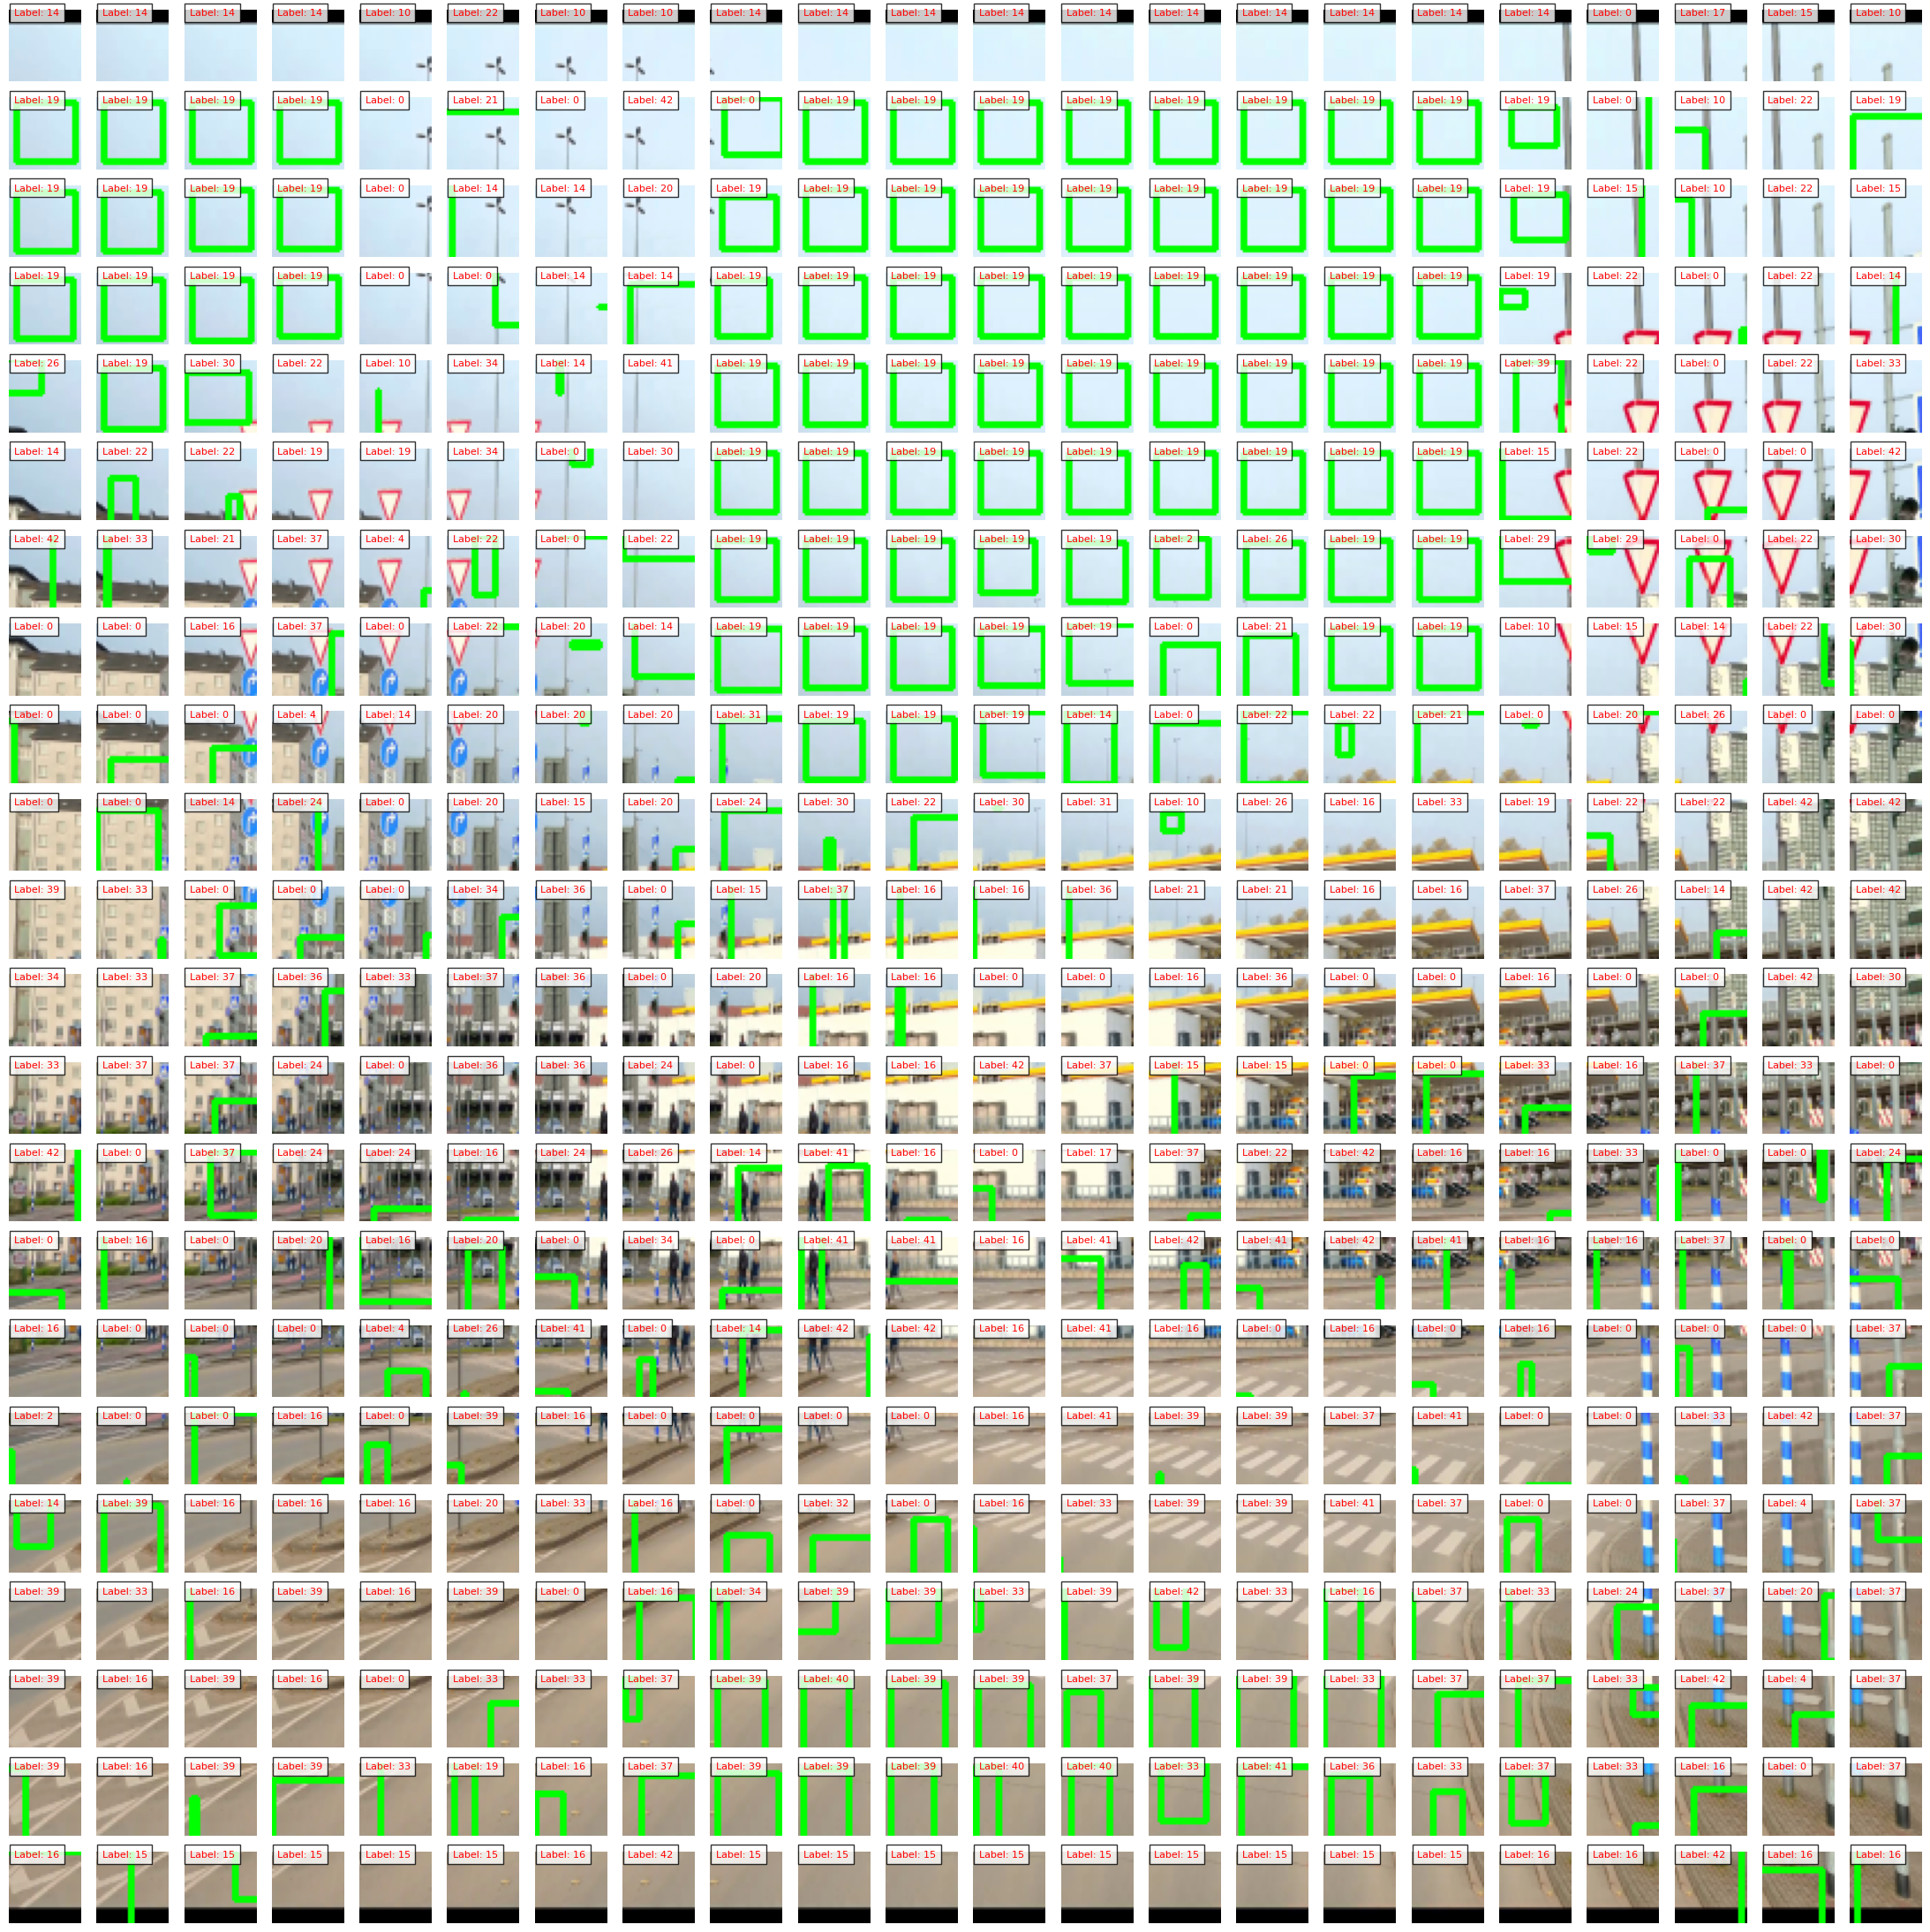

In [19]:
num_rows = 22
num_cols = 22

fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, 22))

for i in range(len(sliding_window_images)):

    row_index = i // num_cols
    col_index = i % num_cols

    ax = axes[row_index, col_index]

    resized_image = cv2.resize(sliding_window_images[i], (32, 32))

    input_image = np.expand_dims(resized_image, axis=0)
    

    predictions = CNN1.predict(input_image)

    class_label = np.argmax(predictions[0])
    roi = predictions[1][0]
    
    x, y, width, height = map(int, roi)
    roi_image = cv2.rectangle(resized_image, (x, y), (x + width, y + height), (0, 255, 0), 2)
    
    ax.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
    ax.text(2, 2, f'Label: {class_label}', color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))
    ax.axis('off')
    
if len(sliding_window_images) < num_rows * num_cols:
    for i in range(len(sliding_window_images), num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]
        ax.axis('off')

plt.tight_layout()
plt.show()

#### Test with images not present in train

Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 4)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
Image shape: (32, 32, 3)
1/1 [==============================] - 0s 110ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 28ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 82ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


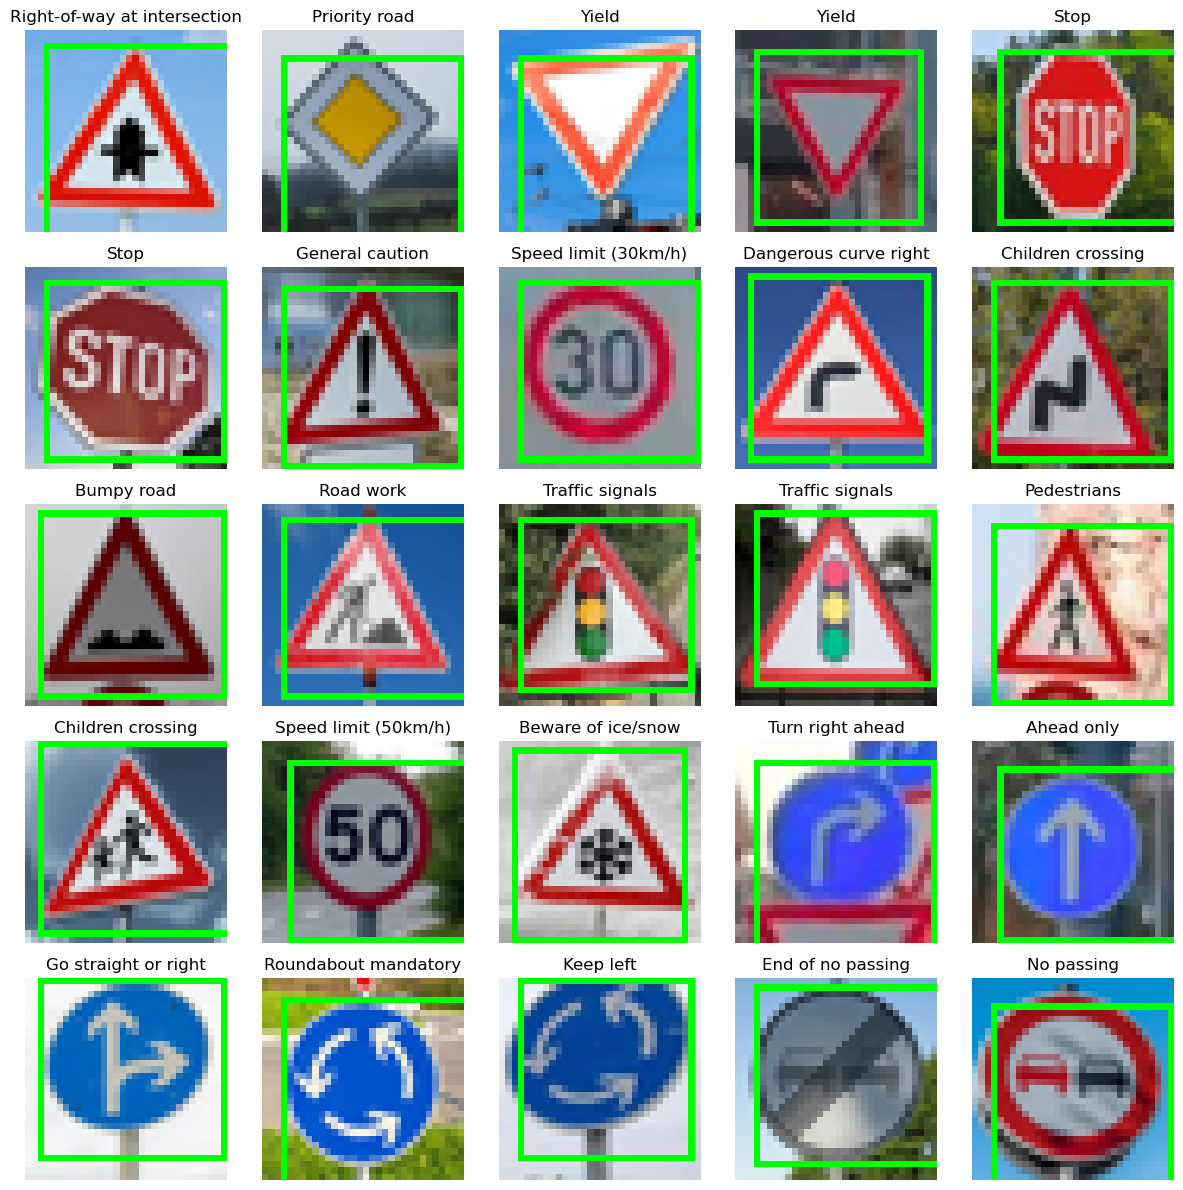

In [14]:
folder_path = "test_images/"

image_files = [file for file in os.listdir(folder_path) if file.endswith((".jpg", ".png", ".jpeg"))]

# Create empty lists to store images and labels
images = []
labels = []

for file in image_files:
    # Extract the label from the file name
    label = int(file.split("_")[0])
    
    image_path = os.path.join(folder_path, file)
    image = Image.open(image_path)
    
    image = image_preprocessing(image)
    
    if image.shape[2] == 3:
        image_array = np.array(image)

        image_array = image_array / 255.0

        images.append(image_array)
        labels.append(label)

images = np.stack(images)
labels = np.array(labels)

fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    image = images[i]
    
    image = np.expand_dims(image, axis=0)
    
    pred = CNN1.predict(image)
    confidence_values = pred[0][0]
    predicted_label = np.argmax(confidence_values)
    label = classes[predicted_label]
    
    predicted_roi = pred[1][0]
    x, y, width, height = map(int, predicted_roi)
    
    roi_image = cv2.rectangle(image[0], (x, y), (x + width, y + height), (0, 255, 0), 1)
    
    ax.imshow(roi_image)
    ax.set_title(f'{label}')
    ax.axis('off')
    
fig.tight_layout()
plt.show()